# MC simulations using R feature selection 


In [1]:
import os
from sys import stdout

import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import learning_curve

from deap import base
from deap import creator
from deap import tools

from feature_selection import *
from utils import *


import warnings
warnings.filterwarnings('ignore')

# Data loading

In [12]:
#x_df = pd.read_csv('./al_basic.csv', sep = ',')
#x_df = pd.read_csv('./al_norm.csv', sep = ',')
#x_df = pd.read_csv('./al_snv.csv', sep = ',')
x_df = pd.read_csv('./al_sum.csv', sep = ',')
#x_df = pd.read_csv('./al_max.csv', sep = ',')


values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(27, 4094)
(4094,)
27


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500,440.777500
0,-0.000102,-0.000237,-0.000178,-0.000282,-0.000095,-0.000278,-0.000104,-0.000109,-0.000075,-0.000166,...,0.000087,-0.000089,0.000089,-0.000091,0.000072,0.000011,0.000071,-0.000040,0.000083,-0.000076
1,-0.000087,-0.000209,-0.000155,-0.000254,-0.000082,-0.000247,-0.000086,-0.000091,-0.000062,-0.000148,...,0.000077,-0.000064,0.000105,-0.000041,0.000108,0.000034,0.000073,-0.000034,0.000073,-0.000071
2,-0.000095,-0.000227,-0.000170,-0.000269,-0.000090,-0.000268,-0.000101,-0.000106,-0.000073,-0.000160,...,0.000075,-0.000062,0.000135,-0.000005,0.000165,0.000073,0.000115,0.000030,0.000175,0.000032
3,-0.000067,-0.000206,-0.000149,-0.000253,-0.000062,-0.000271,-0.000104,-0.000116,-0.000080,-0.000156,...,0.000104,-0.000030,0.000194,0.000051,0.000246,0.000112,0.000109,-0.000037,0.000089,-0.000091
4,-0.000059,-0.000181,-0.000132,-0.000226,-0.000056,-0.000237,-0.000088,-0.000096,-0.000067,-0.000138,...,0.000070,-0.000079,0.000093,-0.000067,0.000092,0.000018,0.000058,-0.000054,0.000063,-0.000092
5,-0.000061,-0.000174,-0.000126,-0.000217,-0.000054,-0.000229,-0.000086,-0.000094,-0.000066,-0.000131,...,0.000086,-0.000004,0.000193,0.000096,0.000272,0.000133,0.000116,0.000003,0.000113,-0.000024
6,-0.000069,-0.000200,-0.000146,-0.000248,-0.000062,-0.000264,-0.000103,-0.000112,-0.000080,-0.000151,...,0.000087,-0.000084,0.000103,-0.000073,0.000099,0.000025,0.000074,-0.000049,0.000080,-0.000092
7,-0.000063,-0.000193,-0.000139,-0.000235,-0.000059,-0.000256,-0.000100,-0.000110,-0.000079,-0.000145,...,0.000083,-0.000079,0.000108,-0.000059,0.000103,0.000030,0.000072,-0.000047,0.000079,-0.000093
8,-0.000057,-0.000164,-0.000118,-0.000201,-0.000053,-0.000211,-0.000079,-0.000088,-0.000062,-0.000122,...,0.000060,-0.000079,0.000069,-0.000070,0.000070,0.000016,0.000060,-0.000025,0.000082,-0.000043
9,-0.000068,-0.000206,-0.000151,-0.000252,-0.000065,-0.000268,-0.000102,-0.000114,-0.000080,-0.000154,...,0.000084,-0.000098,0.000088,-0.000099,0.000071,0.000009,0.000069,-0.000047,0.000090,-0.000084


[[188.1951 188.2601 188.325  ... 440.6714 440.7245 440.7775]]
wl shape:  (4094, 1)


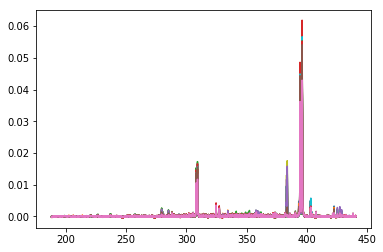

In [13]:
#This is just for visualizing the various plots of the samples
mat = scipy.io.loadmat("./data/002_29-Granges6958-v-335_200Hz_QS295_trig1435_int0.1.mat")
wl= mat["wl"]
print(wl.T)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show()

In [14]:
print(wl[0])
print(wl[-1])

[188.1951]
[440.7775]


In [15]:
df_y = pd.read_csv('./al_concentration_final.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,2:10])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(27, 14)


,Measurement,Reference material,Si,Fe,Mg,Ti,Ni,Zn,Cu,Mn,Pb,Sn,Cr,Al
0,1,Pech. 68451,0.070,0.100,0.4100,0.0400,0.0400,0.180,0.060,1.4500,0.0000,0.0000,0.0000,97.6
1,2,Gränges al 6958-v-335,0.180,0.350,2.0300,0.0600,0.0000,6.080,1.350,0.4500,0.0000,0.0000,0.1000,89.4
2,3,4343-AA,7.460,0.530,0.0360,0.0450,0.0310,0.140,0.150,0.1000,0.0000,0.0000,0.0000,91.4
3,10,Pech. 1206,3.000,0.795,0.5700,0.0930,0.3010,0.154,4.290,0.0370,0.1000,0.2000,0.0000,90.5
4,11,Gränges al 6958-v-331,0.120,0.300,3.0400,0.0290,0.0000,4.930,1.850,0.0600,0.0000,0.0000,0.4000,89.3
5,12,NIST 1255a,7.220,0.140,0.3600,0.1540,0.0180,0.084,0.120,0.0530,0.0000,0.0000,0.0000,91.8
6,14,NBS 1258,0.780,0.079,0.9800,0.0000,0.0010,1.030,0.840,0.4800,0.0000,0.0000,0.0000,95.8
7,15,O 2:3,6.160,0.000,0.3630,0.0080,0.0000,0.000,0.006,0.2060,0.0000,0.0000,0.0000,93.3
8,17,NBS 1241a,0.160,0.200,4.5400,0.0320,0.0200,0.052,0.050,0.3800,0.0000,0.0000,0.0000,94.5
9,18,J 2:3,6.120,0.000,0.3200,0.0030,0.0000,0.000,0.005,0.0160,0.0000,0.0000,0.0000,93.5


In [16]:
y_val = concentration[:,8] #2-Si, 3-Fe, 4-Mg, 7-Zn, 8-Cu, 9-Mn (7-Zn but too much sparse)
#print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
y_df.T

(27,)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.06,1.35,0.15,4.29,1.85,0.12,0.84,0.006,0.05,0.005,...,0.056,0.058,0.11,3.1,2.636,0.062,3.6,1.9,0.006,3.478


In [18]:
df_y1=df_y.drop(['Measurement', 'Reference material','Ti','Ni' ,'Pb','Sn' , 'Cr'], axis=1)

,Si,Fe,Mg,Zn,Cu,Mn,Al
0,0.070,0.100,0.4100,0.180,0.060,1.4500,97.6
1,0.180,0.350,2.0300,6.080,1.350,0.4500,89.4
2,7.460,0.530,0.0360,0.140,0.150,0.1000,91.4
3,3.000,0.795,0.5700,0.154,4.290,0.0370,90.5
4,0.120,0.300,3.0400,4.930,1.850,0.0600,89.3
5,7.220,0.140,0.3600,0.084,0.120,0.0530,91.8
6,0.780,0.079,0.9800,1.030,0.840,0.4800,95.8
7,6.160,0.000,0.3630,0.000,0.006,0.2060,93.3
8,0.160,0.200,4.5400,0.052,0.050,0.3800,94.5
9,6.120,0.000,0.3200,0.000,0.005,0.0160,93.5


In [19]:
print(df_y1.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
     Si &     Fe &      Mg &     Zn &     Cu &      Mn &    Al \\
\midrule
  0.070 &  0.100 &  0.4100 &  0.180 &  0.060 &  1.4500 &  97.6 \\
  0.180 &  0.350 &  2.0300 &  6.080 &  1.350 &  0.4500 &  89.4 \\
  7.460 &  0.530 &  0.0360 &  0.140 &  0.150 &  0.1000 &  91.4 \\
  3.000 &  0.795 &  0.5700 &  0.154 &  4.290 &  0.0370 &  90.5 \\
  0.120 &  0.300 &  3.0400 &  4.930 &  1.850 &  0.0600 &  89.3 \\
  7.220 &  0.140 &  0.3600 &  0.084 &  0.120 &  0.0530 &  91.8 \\
  0.780 &  0.079 &  0.9800 &  1.030 &  0.840 &  0.4800 &  95.8 \\
  6.160 &  0.000 &  0.3630 &  0.000 &  0.006 &  0.2060 &  93.3 \\
  0.160 &  0.200 &  4.5400 &  0.052 &  0.050 &  0.3800 &  94.5 \\
  6.120 &  0.000 &  0.3200 &  0.000 &  0.005 &  0.0160 &  93.5 \\
  0.350 &  0.270 &  2.7800 &  5.370 &  1.600 &  0.2900 &  89.1 \\
  0.260 &  0.420 &  1.2600 &  0.020 &  0.004 &  1.1600 &  96.8 \\
  8.750 &  0.460 &  1.7100 &  0.029 &  2.000 &  0.0560 &  85.3 \\
  0.530 &  0.230 &  0.7700 &  0.0

### wavelenght selection import

In [7]:
sel= pd.read_csv('./selected_wavelengths/selecta_Cu2_ipls500_sum.txt', sep= ' |,|\n', header = None)
#sel= sel.dropna()
#print(sel, "\n")
sel= sel.values.flatten()
sel= sel[~np.isnan(sel)]
sel = [int(i)-1 for i in sel]
print("number of selected wavelengths: ", len(sel))
#print(sel)

number of selected wavelengths:  24


In [8]:
sel=sel[:-1]
#print(wl.shape)
wl_sel= wl[sel]
print(wl_sel.shape)
wl_sel.T

(23, 1)


array([[269.2548, 269.3194, 269.384 , 269.4485, 269.5131, 269.5777,
        269.6423, 269.7068, 295.9944, 296.0583, 296.1223, 296.1862,
        296.2501, 296.314 , 296.3779, 296.4419, 311.7856, 311.849 ,
        311.9124, 311.9758, 312.0392, 312.1026, 312.166 ]])

In [9]:
#target = [251.59, 288.12, 390.60] #peaks for Si
#target = [277.91, 279.59, 280.23, 281.78, 285.27, 383.74] #peaks for Mg
#target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56] #peaks for Mn
target= [296.06,324.73, 327.37] #peaks for Cu
#target= [202.60, 206.20, 213.90, 330.14, 334.41] #peaks for Zn
#target= [310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04] #Fe#
#target = [251.59, 288.12, 390.60, 277.91, 279.59, 280.23, 281.78, 383.74, 285.27, 292.83, 293.61, 294.91, 403.25, 404.63, 404.56, 296.06,324.73, 327.37, 330.14, 334.41, 310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04]
#len(target)

In [10]:
a = []
b = []
for t in target:
    for i in range(len(wl_sel)):
        if abs(wl_sel[i][0]-t) <= 0.2:
            a.append(wl_sel[i][0])
            b.append(i)
            
print("number of selected peaks: ",len(a), "\n")
print(a, "\n")
#print(b)

number of selected peaks:  5 

[295.9944, 296.0583, 296.1223, 296.1862, 296.2501] 



For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

For Copper (Cu) the peaks are at **296.06,324.73, 327.37**

For Zinc (Zn) the peaks are at **202.55, 206.20, 213.90, 330.14, 334.41**

In [11]:
x_selecta = pd.DataFrame(x_df.values[:,sel])
#x_selecta = pd.DataFrame(x_df.values[:,b])
x_selecta

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.000249,-0.000137,0.000053,-0.000147,0.000078,-0.000094,0.000080,0.000020,0.000485,-0.000099,...,-0.000050,0.000105,-0.000060,0.000156,-0.000056,0.000127,-0.000004,0.000073,-0.000165,0.000090
1,0.000216,-0.000126,0.000045,-0.000143,0.000067,-0.000086,0.000075,0.000037,0.000436,-0.000086,...,-0.000057,0.000091,-0.000064,0.000148,-0.000041,0.000126,0.000010,0.000075,-0.000154,0.000079
2,0.000244,-0.000138,0.000049,-0.000140,0.000074,-0.000090,0.000072,0.000004,0.000467,-0.000099,...,-0.000046,0.000095,-0.000053,0.000164,-0.000037,0.000132,0.000005,0.000079,-0.000149,0.000095
3,0.000272,-0.000149,0.000057,-0.000150,0.000084,-0.000098,0.000078,-0.000003,0.000525,-0.000082,...,-0.000046,0.000104,-0.000055,0.000148,-0.000070,0.000117,-0.000020,0.000063,-0.000171,0.000086
4,0.000233,-0.000132,0.000049,-0.000138,0.000072,-0.000086,0.000072,0.000017,0.000451,-0.000088,...,-0.000053,0.000086,-0.000061,0.000138,-0.000043,0.000118,0.000002,0.000083,-0.000145,0.000079
5,0.000218,-0.000126,0.000045,-0.000129,0.000068,-0.000083,0.000066,0.000006,0.000421,-0.000097,...,-0.000050,0.000079,-0.000054,0.000142,-0.000035,0.000118,0.000006,0.000068,-0.000140,0.000074
6,0.000266,-0.000141,0.000057,-0.000145,0.000084,-0.000092,0.000079,0.000004,0.000509,-0.000092,...,-0.000038,0.000108,-0.000049,0.000137,-0.000072,0.000110,-0.000024,0.000059,-0.000164,0.000085
7,0.000256,-0.000139,0.000055,-0.000136,0.000081,-0.000087,0.000075,-0.000007,0.000491,-0.000091,...,-0.000033,0.000103,-0.000046,0.000138,-0.000066,0.000111,-0.000021,0.000061,-0.000147,0.000091
8,0.000202,-0.000116,0.000042,-0.000121,0.000063,-0.000078,0.000062,0.000008,0.000394,-0.000084,...,-0.000042,0.000081,-0.000051,0.000133,-0.000036,0.000108,-0.000001,0.000062,-0.000126,0.000076
9,0.000270,-0.000145,0.000058,-0.000142,0.000085,-0.000091,0.000078,-0.000003,0.000516,-0.000094,...,-0.000033,0.000112,-0.000047,0.000157,-0.000056,0.000127,-0.000010,0.000073,-0.000153,0.000100


## Partial Least Squares

In [21]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
#for i in range(100,116):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    plscomp = optimise_pls_cv(X_train, y_train, min(30, X_train.shape[1]), plot_components=False) 

    #PLS model
    #pls =  PLSRegression(n_components=max(6, plscomp), scale=False)
    pls =  PLSRegression(n_components=max(6,plscomp), scale=True)
    #pls =  PLSRegression(n_components=plscomp, scale=True)
    #pls =  PLSRegression(n_components=plscomp, scale=False)

    # Fit
    pls.fit(X_train, y_train)

    y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
    y_pred = pls.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  100
100% completed
Suggested number of components:  20

seed:  101
100% completed
Suggested number of components:  11

seed:  102
100% completed
Suggested number of components:  12

seed:  103
100% completed
Suggested number of components:  7

seed:  104
100% completed
Suggested number of components:  10

seed:  105
100% completed
Suggested number of components:  12

seed:  106
100% completed
Suggested number of components:  10

seed:  107
100% completed
Suggested number of components:  8

seed:  108
100% completed
Suggested number of components:  8

seed:  109
100% completed
Suggested number of components:  9

seed:  110
100% completed
Suggested number of components:  12

seed:  111
100% completed
Suggested number of components:  8

seed:  112
100% completed
Suggested number of components:  7

seed:  113
100% completed
Suggested number of components:  8

seed:  114
100% completed
Suggested number of components:  18

seed:  115
100% completed
Suggested number of components:  10


## Simple Linear Model

In [13]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, y_train)

    predictions = lm.predict(X_test)
    y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.8905144336792207
std dev:  0.23595511015513979

rmse:
mean:  0.2438306844160371
std dev:  0.1503896933513156

0.8905144336792207
0.23595511015513979

0.2438306844160371
0.1503896933513156


## Elastic Net

In [14]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

    mses = []

    for a in alphas:
        model = ElasticNet(alpha=a).fit(X_train,y_train)   

        y_cv = cross_val_predict(model, X_train, y_train, cv=10)
        mse = mean_squared_error(y_train, y_cv)
        score = model.score(X_train, y_train)
        #pred_y = model.predict(X_test)
        #mse = mean_squared_error(y_test, pred_y)
        mses.append(mse)
        #print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))
        
    best_index =np.argmin(mses)
    print("best alpha: ", alphas[best_index], "\n")
    
    model = ElasticNet(alpha=alphas[best_index]).fit(X_train,y_train)   

    y_cv = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred = model.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
best alpha:  0 

seed:  2
best alpha:  0 

seed:  3
best alpha:  0 

seed:  4
best alpha:  0 

seed:  5
best alpha:  0 

seed:  6
best alpha:  0 

seed:  7
best alpha:  0 

seed:  8
best alpha:  0 

seed:  9
best alpha:  0 

seed:  10
best alpha:  0 

seed:  11
best alpha:  0 

seed:  12
best alpha:  0 

seed:  13
best alpha:  0 

seed:  14
best alpha:  0 

seed:  15
best alpha:  0 

FINAL ESTIMATIONS:
R^2:
mean:  0.9565328401330521
std dev:  0.06826259432199915

rmse:
mean:  0.17498420827432198
std dev:  0.0503179139685266

0.9565328401330521
0.06826259432199915

0.17498420827432198
0.0503179139685266


## Random Forest

In [15]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(6,)
(21,)


In [16]:
## R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    rf = RandomForestRegressor(n_estimators = 1000, max_depth=30, random_state = seed)
    # Train the model on training data

    rf.fit(X_train, y_train);

    # Use the forest's predict method on the test data
    #y_cv = cross_val_predict(rf, X_train, y_train, cv=10)
    predictions = rf.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.7287209716022122
std dev:  0.371608078000429

rmse:
mean:  0.7450549865798891
std dev:  0.29227919390675466

0.7287209716022122
0.371608078000429

0.7450549865798891
0.29227919390675466


## SVM

In [17]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    X_train = StandardScaler().fit_transform(X_train.values)
    X_test = StandardScaler().fit_transform(X_test.values)
    
    #KFold cross validator
    kf = KFold(n_splits=5, shuffle=True, random_state=seed) 

    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]
    accuracy_scores=[]

    # Do model selection over all the possible values of gamma
    for gamma in gamma_values:
        # Train a classifier with current gamma
        svr = SVR(kernel='linear', C=gamma)

        # Compute cross-validated accuracy scores
        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


        accuracy_score = scores.mean()
        accuracy_scores.append(accuracy_score)

    # Get the gamma with highest mean accuracy
    best_index = np.array(accuracy_scores).argmax()
    best_gamma = gamma_values[best_index]
    #print("best index: ",best_index)
    #print("best gamma: ", best_gamma)

    # Train over the full training set with the best gamma
    svr = SVR( kernel='linear', C=best_gamma)
    svr.fit(X_train, y_train)

    # Evaluate on the test set 
    y_pred = svr.predict(X_test)
    #cross-val results
    y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    X_train = StandardScaler().fit_transform(X_train.values)\n    X_test = StandardScaler().fit_transform(X_test.values)\n    \n    #KFold cross validator\n    kf = KFold(n_splits=5, shuffle=True, random_state=seed) \n\n    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]\n    accuracy_scores=[]\n\n    # Do model selection over all the possible values of gamma\n    for gamma in gamma_values:\n        # Train a classifier with current gamma\n        svr = SVR(kernel=\'linear\', C=gamma)\n\n        # Compute cross-validated accuracy scores\n        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = \'r2\' )\n\n\n        accuracy_score = scores.mean()\n  

## PCR

In [18]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) 

    # PCA
    X_std = StandardScaler().fit_transform(X_train)
    X_std_test = StandardScaler().fit_transform(X_test)

    pca = PCA(n_components= min(X_train.shape[0], pca_comp))
    PC=pca.fit(X_std)

    x_pc = pca.fit_transform(X_std)
    x_test_pc = pca.transform(X_std_test)
    #print(x_pc.shape)
    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
    
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(x_pc, y_train)

    # Cross-validation and prediction
    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)
    y_pred = regr.predict(x_test_pc)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse_p = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse_p)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    #cross validation to find optimal number of components\n    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) \n\n    # PCA\n    X_std = StandardScaler().fit_transform(X_train)\n    X_std_test = StandardScaler().fit_transform(X_test)\n\n    pca = PCA(n_components= min(X_train.shape[0], pca_comp))\n    PC=pca.fit(X_std)\n\n    x_pc = pca.fit_transform(X_std)\n    x_test_pc = pca.transform(X_std_test)\n    #print(x_pc.shape)\n    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))\n    \n    regr = linear_model.LinearRegression()\n    # Fit\n    regr.fit(x_pc, y_train)\n\n    # Cross-validation and prediction\n    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)\n